<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Анализ-данных" data-toc-modified-id="Анализ-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ данных</a></span></li><li><span><a href="#Модель" data-toc-modified-id="Модель-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Модель</a></span></li></ul></div>

# Восстановление золота из руды

Подготовьте прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. Используйте данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Вам нужно:

1. Подготовить данные;
2. Провести исследовательский анализ данных;
3. Построить и обучить модель.

Чтобы выполнить проект, обращайтесь к библиотекам *pandas*, *matplotlib* и *sklearn.* Вам поможет их документация.

Данные находятся в трёх файлах:  
*	gold_recovery_train_new.csv — обучающая выборка;
*	gold_recovery_test_new.csv — тестовая выборка;
*	gold_recovery_full_new.csv — исходные данные.

Данные индексируются датой и временем получения информации (признак date). Соседние по времени параметры часто похожи.
Некоторые параметры недоступны, потому что замеряются и/или рассчитываются значительно позже. Из-за этого в тестовой выборке отсутствуют некоторые признаки, которые могут быть в обучающей. Также в тестовом наборе нет целевых признаков.
Исходный датасет содержит обучающую и тестовую выборки со всеми признаками.

**Технологический процесс производства золота**  
**1. Флотация**  
Во флотационную установку подаётся смесь золотосодержащей руды. После обогащения получается черновой концентрат и «отвальные хвосты», то есть остатки продукта с низкой концентрацией ценных металлов.
На стабильность этого процесса влияет непостоянное и неоптимальное физико-химическое состояние флотационной пульпы (смеси твёрдых частиц и жидкости).  
**2. Очистка**  
Черновой концентрат проходит две очистки. На выходе получается финальный концентрат и новые отвальные хвосты.

**Описание данных**  
**Технологический процесс**
*	Rougher feed — исходное сырье
*   Rougher additions (или reagent additions) — флотационные реагенты: Xanthate (ксантогенат (промотер, или активатор флотации), Sulphate(сульфат (на данном производстве сульфид натрия), Depressant (депрессант (силикат натрия)
*	Rougher process (англ. «грубый процесс») — флотация
*	Rougher tails — отвальные хвосты
*	Float banks — флотационная установка
*	Cleaner process — очистка
*	Rougher Au — черновой концентрат золота
*	Final Au — финальный концентрат золота  

**Параметры этапов**
*	air amount — объём воздуха
*	fluid levels — уровень жидкости
*	feed size — размер гранул сырья
*	feed rate — скорость подачи


## Подготовка данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.model_selection import GridSearchCV

In [2]:
try:
    gold_recovery_train = pd.read_csv('/datasets/gold_recovery_train_new.csv') #обучающая выборка
    gold_recovery_test = pd.read_csv('/datasets/gold_recovery_test_new.csv') #тестовая выборка 
    gold_recovery_full = pd.read_csv('/datasets/gold_recovery_full_new.csv') #исходные данные
except FileNotFoundError:
    display('Sorry, the file does not exist')

In [3]:
dfs_all = [gold_recovery_train, gold_recovery_test, gold_recovery_full]
dfs = [gold_recovery_train, gold_recovery_test]

gold_recovery_train.name = 'gold_recovery_train'   
gold_recovery_test.name = 'gold_recovery_test'
gold_recovery_full.name = 'gold_recovery_full'

pd.set_option('display.max_columns', None)

for df in dfs_all:
    display(df.name, df.head())

'gold_recovery_train'

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,10.128295,7.25,0.988759,8.547551,10.389648,19.529297,34.174427,14.936526,2.534912,7.476074,2.106679,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,41885.707031,3481.779053,3520.337158,2.838687,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,11.500771,7.101074,28.029297,19.793808,87.107763,5.008018,0.508728,19.154297,1.170244,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,14.500184,4.694824,8.764648,2.606185,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,10.296251,7.25,1.002663,8.558743,10.

'gold_recovery_test'

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,-500.704369,1399.001695,-499.485144,13.128569,5.636710,489.793655,62.710452,42.022440,12.084103,16.922877,6.153479,16.867518,6.150709,1001.849317,-350.301265,1249.738612,-399.107531,1249.750520,-399.396730,1198.287855,-399.488594,999.472250,-399.530962,949.566189,-398.180807,24.938200,-500.490963,14.947607,-500.013837,20.018166,-450.395995,13.987058,-449.831513,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,-499.240168,1399.508091,-500.416324,13.036280,5.526065,490.104534,61.961163,41.187903,11.918977,17.002532,5.999043,16.996063,6.002315,998.690785,-350.425704,1248.395457,-399.946025,1249.514451,-399.630810,1200.506459,-399.942434,1000.002114,-399.491528,950.200009,-405.787514,24.923466,-499.813963,14.930873,-500.764452,19.988503,-450.114024,14.092981,-450.059163,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,-502.151509,1399.497088,-499.715479,13.138412,5.426561,489.617969,66.903807,42.546294,12.091332,16.992520,5.850632,16.982096,5.853594,998.516720,-349.783538,1247.440748,-400.264330,1248.207204,-401.074405,1199.770026,-400.790582,999.925519,-399.236999,950.320481,-400.864340,24.908732,-500.304035,14.996511,-500.993821,20.039689,-450.263164,14.077881,-449.660997,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,-498.355873,1401.065165,-501.038738,12.400507,5.114758,476.618130,59.865919,41.060195,12.181597,16.532144,5.801935,16.515277,5.803657,1000.276604,-350.172597,1251.322675,-398.655289,1250.493702,-399.746728,1199.398691,-397.50

'gold_recovery_full'

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,10.128295,7.25,0.988759,8.547551,10.389648,19.529297,34.174427,14.936526,2.534912,7.476074,2.106679,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,41885.707031,3481.779053,3520.337158,2.838687,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,11.500771,7.101074,28.029297,19.793808,87.107763,5.008018,0.508728,19.154297,1.170244,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,14.500184,4.694824,8.764648,2.606185,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,10.296251,7.25,1.002663,8.558743,10.

In [4]:
for df in dfs_all:
    display(df.info())

<class 'pandas.core.frame.DataFrame'>

RangeIndex: 14149 entries, 0 to 14148

Data columns (total 87 columns):

 #   Column                                              Non-Null Count  Dtype  

---  ------                                              --------------  -----  

 0   date                                                14149 non-null  object 

 1   final.output.concentrate_ag                         14148 non-null  float64

 2   final.output.concentrate_pb                         14148 non-null  float64

 3   final.output.concentrate_sol                        13938 non-null  float64

 4   final.output.concentrate_au                         14149 non-null  float64

 5   final.output.recovery                               14149 non-null  float64

 6   final.output.tail_ag                                14149 non-null  float64

 7   final.output.tail_pb                                14049 non-null  float64

 8   final.output.tail_sol                               14144 non-n

None

<class 'pandas.core.frame.DataFrame'>

RangeIndex: 5290 entries, 0 to 5289

Data columns (total 53 columns):

 #   Column                                      Non-Null Count  Dtype  

---  ------                                      --------------  -----  

 0   date                                        5290 non-null   object 

 1   primary_cleaner.input.sulfate               5286 non-null   float64

 2   primary_cleaner.input.depressant            5285 non-null   float64

 3   primary_cleaner.input.feed_size             5290 non-null   float64

 4   primary_cleaner.input.xanthate              5286 non-null   float64

 5   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64

 6   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64

 7   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64

 8   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64

 9   primary_cleaner.state.floatbank8_c_air      5290 non-null   float64

 1

None

<class 'pandas.core.frame.DataFrame'>

RangeIndex: 19439 entries, 0 to 19438

Data columns (total 87 columns):

 #   Column                                              Non-Null Count  Dtype  

---  ------                                              --------------  -----  

 0   date                                                19439 non-null  object 

 1   final.output.concentrate_ag                         19438 non-null  float64

 2   final.output.concentrate_pb                         19438 non-null  float64

 3   final.output.concentrate_sol                        19228 non-null  float64

 4   final.output.concentrate_au                         19439 non-null  float64

 5   final.output.recovery                               19439 non-null  float64

 6   final.output.tail_ag                                19438 non-null  float64

 7   final.output.tail_pb                                19338 non-null  float64

 8   final.output.tail_sol                               19433 non-n

None

Первичный анализ данных о характеристиках обогащения золота показал:
1. В таблице представлена информация: 
* data — индекс, отражающий дату и время получения информации;
* показатели процесса обогащения, где наименование признаков: [этап].[тип_параметра].[название_параметра]   

***Пример: rougher.input.feed_ag***  

Возможные значения для блока [этап]:
*	rougher — флотация
*	primary_cleaner — первичная очистка
*	secondary_cleaner — вторичная очистка
*	final — финальные характеристики 

Возможные значения для блока [тип_параметра]:
*	input — параметры сырья
*	output — параметры продукта
*	state — параметры, характеризующие текущее состояние этапа
*	calculation — расчетные характеристик


2. В выборках есть пропуски.
3. Во всех датафреймах data - object (строки), остальные признаки - float64 (вещественные числа). 
4. Тестовая выборка отличается от обучающей отсутствием признаков output на каждом этапе обработки: часть признаков расчетные (содержание можно посчитать через извлечение) и зависят от предыдущего этапа, также два признака целевые  - rougher.output.recovery, final.output.recovery. Предположу, что их удалили, чтобы не возникло утечки целевого признака.
5. В тестовой выборке нет признаков calculation для этапа флотации (Rougher process), т.к. это расчетные характеристики.

Выведем признаки, которые доступны только в тестовой выборке.

In [5]:
only_train = set(gold_recovery_train.columns) - set(gold_recovery_test.columns)
only_train

{'final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',
 'rougher.output.ta

Проверим, что эффективность обогащения рассчитана правильно. Вычислим ее на обучающей выборке для признака rougher.output.recovery и найдем MAE между расчетными и целевыми значенияем признака. 

In [6]:
#сформируем функцию, которая расчитывает эффективность обогащения
#если в знаменателе 0, меняем на значение из исходной таблицы
def recovery_rougher(row):
    C = row['rougher.output.concentrate_au'] #доля золота в концентрате после флотации/очистки
    F = row['rougher.input.feed_au'] #доля золота в сырье/концентрате до флотации/очистки
    T = row['rougher.output.tail_au'] #доля золота в отвальных хвостах после флотации/очистки
    calc = row['rougher.output.recovery'] #целовое значение rougher.output.recovery
    if (F * (C-T)) == 0: 
        R = сalc
    else: R = 100* ((C * (F-T)) / (F * (C-T)))   
    return R


#рассчитаем recovery для этапа флотация
gold_recovery_train['rougher.calculation.recovery'] = gold_recovery_train.apply(recovery_rougher,axis=1)

#определим непустые ячейки
mae_index = gold_recovery_train['rougher.output.recovery'].notna()

#проверим количество пропусков:
display(gold_recovery_train.loc[mae_index]['rougher.calculation.recovery'].isna().sum())
display(gold_recovery_train.loc[mae_index]['rougher.output.recovery'].isna().sum())


#поссчитаем MAE:
display('Среднее абсолютное отклонение: ', mean_absolute_error(gold_recovery_train.loc[mae_index]['rougher.output.recovery'], gold_recovery_train.loc[mae_index]['rougher.calculation.recovery']))

0

0

'Среднее абсолютное отклонение: '

9.73512347450521e-15

Таким образом, расчетное значения отклоняется от истинных значений rougher.output.recovery в среднем на очень маленькую величину в степени -15. Это говорит о том, что эффективность обогащения рассчитана правильно. Соответственно считаем, что в дальнейшем данная формула - эталон для расчетов.

Проведем предобработку данных. Проверим на наличие дублей и пропусков.

In [7]:
#проверим на наличие явных дубликатов
#будем считать, что строчки задублированы, если у них повторяются значения в столбце data
for df in dfs:
    display('Количество дублей в датафрейме {}: {}'
            .format(df.name, df[df.duplicated('date', keep=False)]
            .shape[0]))

'Количество дублей в датафрейме gold_recovery_train: 0'

'Количество дублей в датафрейме gold_recovery_test: 0'

In [8]:
#проверим на наличие пропусков и проведем их замену
#посчитаем количество пропусков    
pd.set_option('display.max_rows',None)

display('Количество дублей в обучающей выборке по переменным', gold_recovery_train
        .isna()
        .sum()
        .sort_values(ascending=False)
       )
display('Количество дублей в тестовой выборке по переменным', gold_recovery_test
        .isna()
        .sum()
        .sort_values(ascending=False)
       )

'Количество дублей в обучающей выборке по переменным'

secondary_cleaner.output.tail_sol                     1605
rougher.state.floatbank10_e_air                        436
rougher.input.floatbank11_xanthate                     428
primary_cleaner.output.concentrate_sol                 286
secondary_cleaner.state.floatbank2_a_air               217
final.output.concentrate_sol                           211
rougher.input.feed_size                                144
final.output.tail_pb                                   100
rougher.input.feed_pb                                  100
primary_cleaner.input.xanthate                         100
primary_cleaner.output.concentrate_pb                   86
rougher.input.feed_sol                                  78
primary_cleaner.output.tail_sol                         46
rougher.input.floatbank11_sulfate                       36
primary_cleaner.input.depressant                        32
rougher.input.floatbank10_sulfate                       29
rougher.output.concentrate_sol                          

'Количество дублей в тестовой выборке по переменным'

rougher.input.floatbank11_xanthate            25
rougher.input.feed_sol                        21
secondary_cleaner.state.floatbank3_a_air       9
rougher.input.floatbank11_sulfate              8
primary_cleaner.input.depressant               5
rougher.input.floatbank10_sulfate              5
primary_cleaner.input.xanthate                 4
primary_cleaner.input.sulfate                  4
rougher.input.feed_rate                        3
secondary_cleaner.state.floatbank2_a_air       3
secondary_cleaner.state.floatbank2_b_air       2
rougher.input.feed_size                        1
secondary_cleaner.state.floatbank2_b_level     0
rougher.state.floatbank10_f_level              0
rougher.state.floatbank10_f_air                0
secondary_cleaner.state.floatbank3_a_level     0
secondary_cleaner.state.floatbank2_a_level     0
date                                           0
rougher.state.floatbank10_e_air                0
secondary_cleaner.state.floatbank3_b_air       0
secondary_cleaner.st

In [9]:
#данные индексируются датой и временем получения информации (date). 
#как сказано в задании и видно из первичного анализа cоседние по времени параметры часто похожи.
#поэтому заполняем последним действительным значением вперед
gold_recovery_train = gold_recovery_train.fillna(method='ffill') 
gold_recovery_test = gold_recovery_test.fillna(method='ffill')
    
#посчитаем количество пропусков после замены    
pd.set_option('display.max_rows',None)

display('Количество дублей в обучающей выборке по переменным', gold_recovery_train
        .isna()
        .sum()
        .sort_values(ascending=False)
       )
display('Количество дублей в тестовой выборке по переменным', gold_recovery_test
        .isna()
        .sum()
        .sort_values(ascending=False)
       )

'Количество дублей в обучающей выборке по переменным'

date                                                  0
final.output.concentrate_ag                           0
rougher.state.floatbank10_f_level                     0
rougher.state.floatbank10_f_air                       0
rougher.state.floatbank10_e_level                     0
rougher.state.floatbank10_e_air                       0
rougher.state.floatbank10_d_level                     0
rougher.state.floatbank10_d_air                       0
rougher.state.floatbank10_c_level                     0
rougher.state.floatbank10_c_air                       0
rougher.state.floatbank10_b_level                     0
rougher.state.floatbank10_b_air                       0
rougher.state.floatbank10_a_level                     0
rougher.state.floatbank10_a_air                       0
rougher.output.tail_au                                0
rougher.output.tail_sol                               0
rougher.output.tail_pb                                0
rougher.output.tail_ag                          

'Количество дублей в тестовой выборке по переменным'

date                                          0
rougher.state.floatbank10_c_air               0
rougher.state.floatbank10_d_air               0
rougher.state.floatbank10_d_level             0
rougher.state.floatbank10_e_air               0
rougher.state.floatbank10_e_level             0
rougher.state.floatbank10_f_air               0
rougher.state.floatbank10_f_level             0
secondary_cleaner.state.floatbank2_a_air      0
secondary_cleaner.state.floatbank2_a_level    0
secondary_cleaner.state.floatbank2_b_air      0
secondary_cleaner.state.floatbank2_b_level    0
secondary_cleaner.state.floatbank3_a_air      0
secondary_cleaner.state.floatbank3_a_level    0
secondary_cleaner.state.floatbank3_b_air      0
secondary_cleaner.state.floatbank3_b_level    0
secondary_cleaner.state.floatbank4_a_air      0
secondary_cleaner.state.floatbank4_a_level    0
secondary_cleaner.state.floatbank4_b_air      0
secondary_cleaner.state.floatbank4_b_level    0
secondary_cleaner.state.floatbank5_a_air

## Анализ данных

Проанализируем изменение концентрация металлов (Au, Ag, Pb) на различных этапах очистки.

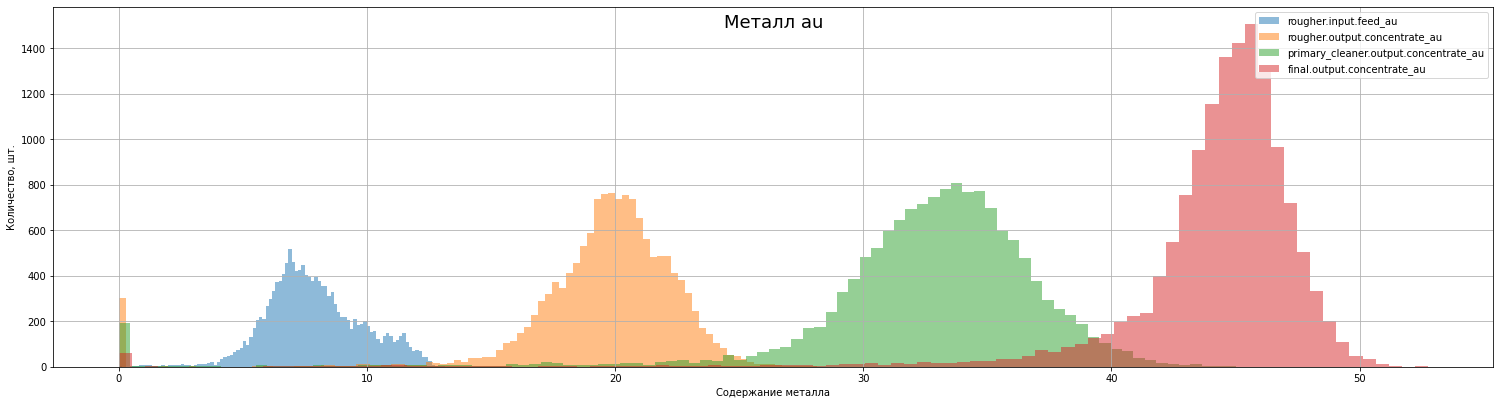

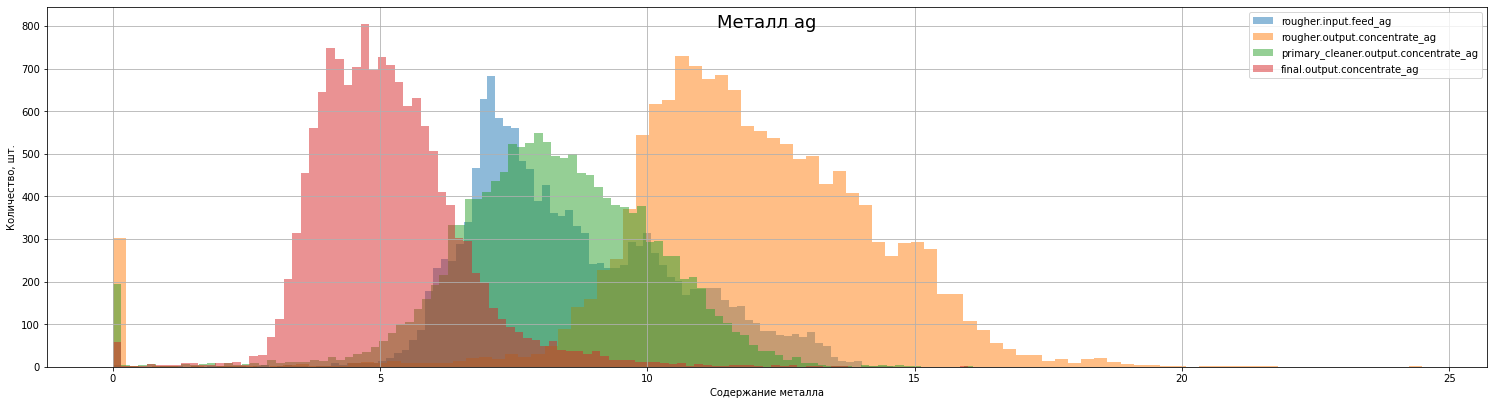

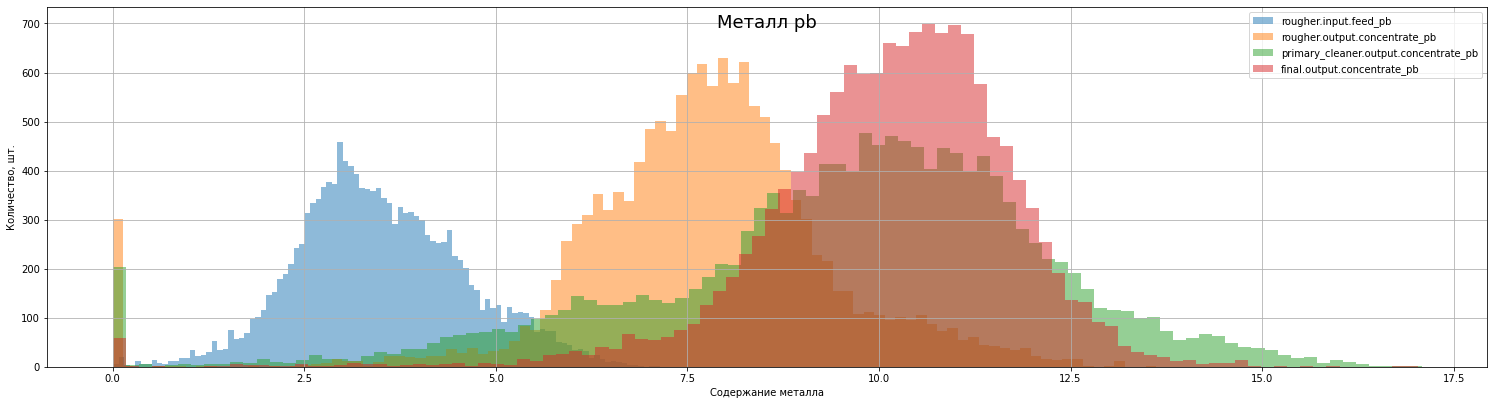

In [10]:
process = ['rougher.input.feed',
           'rougher.output.concentrate',
           'primary_cleaner.output.concentrate',
           'final.output.concentrate']

process_tail = ['rougher.input.feed',
                'rougher.output.tail',
                'primary_cleaner.output.tail',
                'final.output.tail']

metalls = ['au', 'ag', 'pb']
#для концентрата
i = 0

BINS = 100

for element in metalls:
    fig = plt.figure(figsize=(20, 5))
    ax = fig.add_axes([0,0,1,1])
    ax.grid()
    ttl = fig.suptitle('Металл ' + metalls[i], fontsize=18)
    plt.xlabel('Содержание металла')
    plt.ylabel('Количество, шт.')
    for stage in process:
        plt.hist(gold_recovery_train[stage+'_'+metalls[i]],
                 alpha=0.5, 
                 label=stage+'_'+metalls[i], 
                 bins=BINS)
    plt.legend(loc='upper right')
    plt.show()
    i += 1


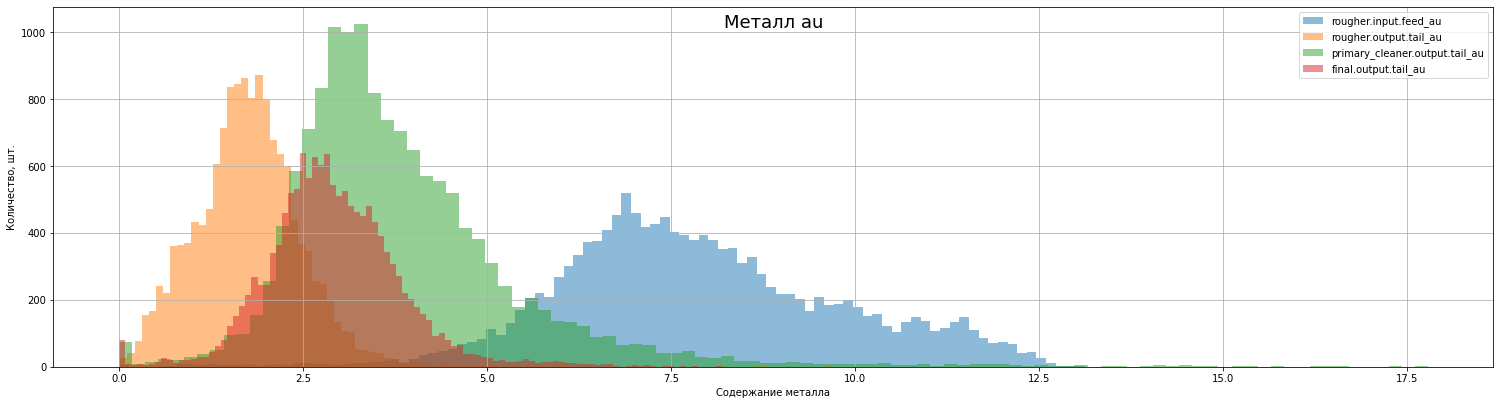

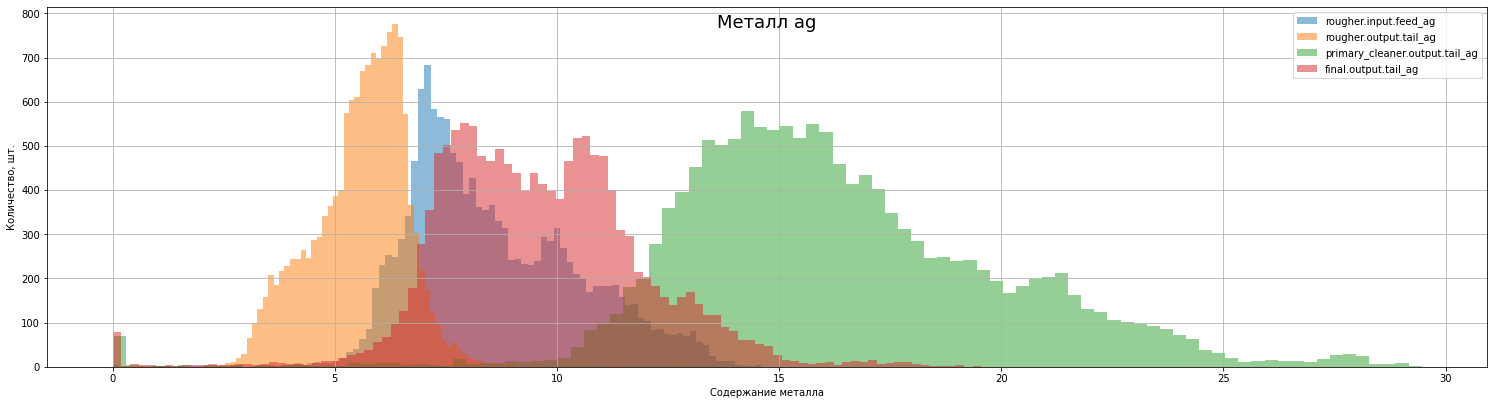

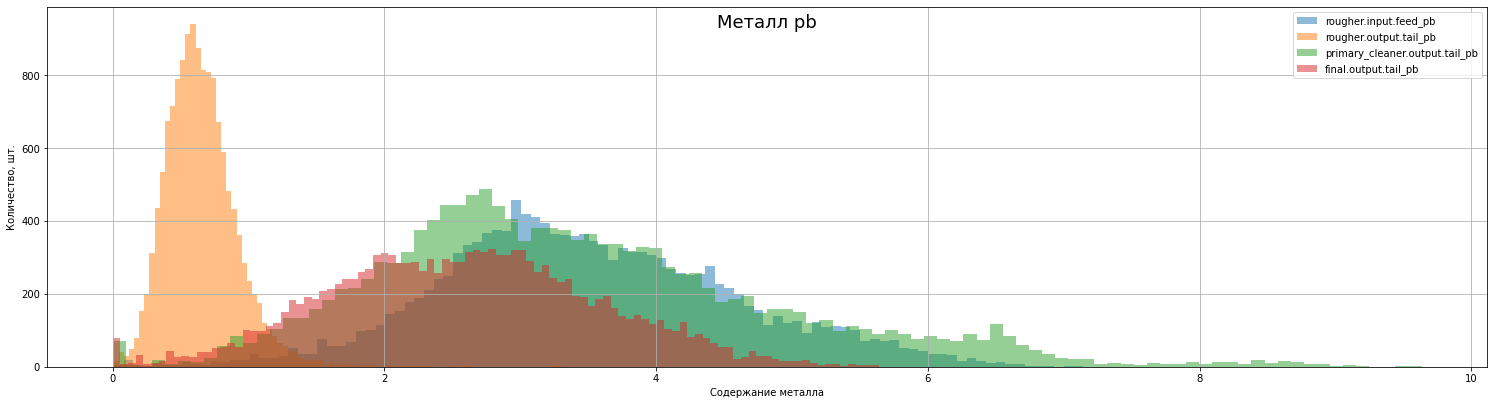

In [11]:
#для хвостов
i = 0

BINS = 100

for element in metalls:
    fig = plt.figure(figsize=(20, 5))
    ax = fig.add_axes([0,0,1,1])
    ax.grid()
    ttl = fig.suptitle('Металл ' + metalls[i], fontsize=18)
    plt.xlabel('Содержание металла')
    plt.ylabel('Количество, шт.')
    for stage in process_tail:
        plt.hist(gold_recovery_train[stage+'_'+metalls[i]], 
                 alpha=0.5, 
                 label=stage+'_'+metalls[i],
                 bins=BINS)
    plt.legend(loc='upper right')
    plt.show()
    
    i += 1

Таким образом, концентрация золота и свинца в продукте с каждым этапом очистке возрастает, а в хвостах падает, что логично, т.к. часть пустой породы уходит в хвосты. Концентрация серебра ведет себя наоборот - после флотации возрастает, а затем с каждым этап падает, а в хвостах наоборот - возрастает.

Сравним распределение размеров гранул сырья на обучающей и тестовой выборках.

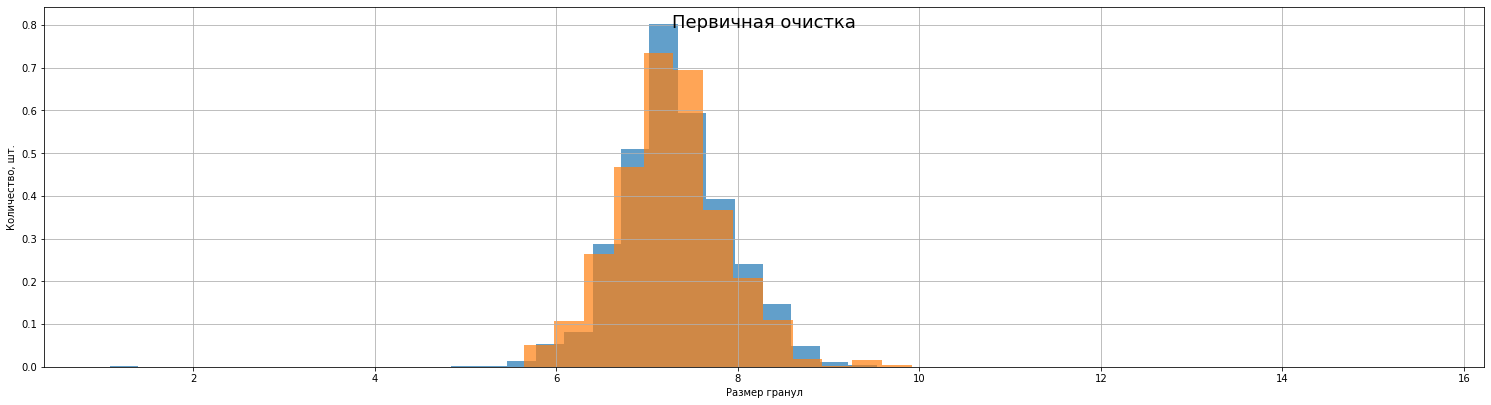

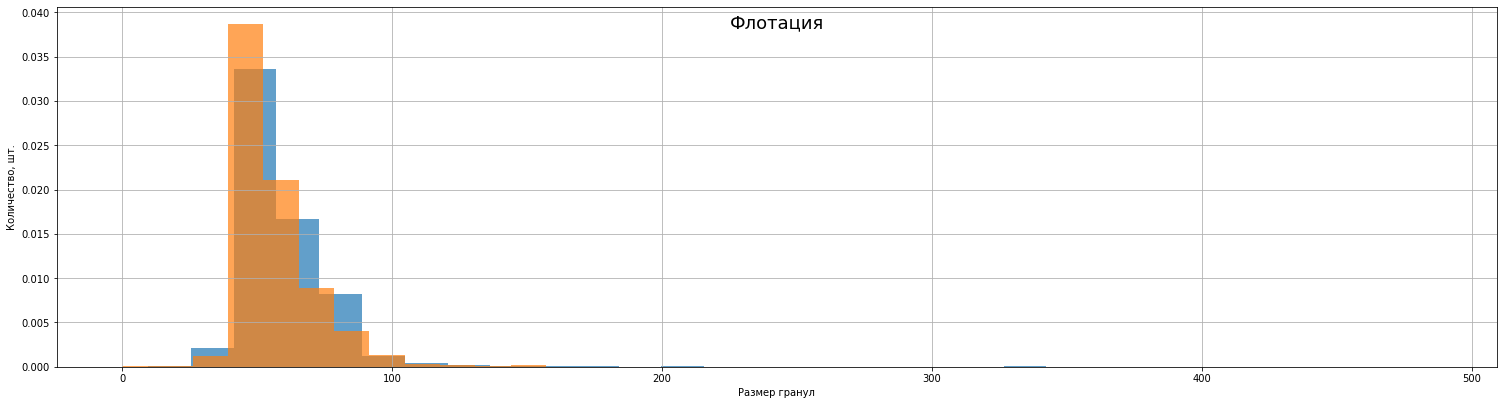

In [12]:
BINS = 30

fig = plt.figure(figsize=(20, 5))
ax = fig.add_axes([0,0,1,1])
ax.grid()
ttl = fig.suptitle('Первичная очистка', fontsize=18)
plt.xlabel('Размер гранул')
plt.ylabel('Количество, шт.')

gold_recovery_train['primary_cleaner.input.feed_size'].hist(alpha=0.7, bins=BINS, density=True)
gold_recovery_test['primary_cleaner.input.feed_size'].hist(alpha=0.7, bins=BINS, density=True)

plt.show()

fig = plt.figure(figsize=(20, 5))
ax = fig.add_axes([0,0,1,1])
ax.grid()
ttl = fig.suptitle('Флотация', fontsize=18)
plt.xlabel('Размер гранул')
plt.ylabel('Количество, шт.')


gold_recovery_train['rougher.input.feed_size'].hist(alpha=0.7, bins=BINS, density=True)
gold_recovery_test['rougher.input.feed_size'].hist(alpha=0.7, bins=BINS, density=True)

plt.show()

Таким образом, распредления совпадают. Следовательно оценка модели будет правильной.

Исследуем суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах.

In [13]:
#сумма концентраций металлов в исходной сырье
gold_recovery_train['sum_input_feed_rougher'] = (
    gold_recovery_train['rougher.input.feed_ag'] + 
    gold_recovery_train['rougher.input.feed_pb'] + 
    gold_recovery_train['rougher.input.feed_sol'] + 
    gold_recovery_train['rougher.input.feed_au']
)


#сумма концентраций металлов после флотации
gold_recovery_train['sum_concentrate_rougher'] = (
    gold_recovery_train['rougher.output.concentrate_ag'] + 
    gold_recovery_train['rougher.output.concentrate_pb'] + 
    gold_recovery_train['rougher.output.concentrate_sol'] + 
    gold_recovery_train['rougher.output.concentrate_au']
)

#сумма концентраций металлов после первичной очистки
gold_recovery_train['sum_primary_cleaner_output_concentrate'] = (
    gold_recovery_train['primary_cleaner.output.concentrate_ag'] + 
    gold_recovery_train['primary_cleaner.output.concentrate_pb'] + 
    gold_recovery_train['primary_cleaner.output.concentrate_sol'] +
    gold_recovery_train['primary_cleaner.output.concentrate_au']
)

#сумма концентраций металлов после финальной очистки
gold_recovery_train['sum_final_output_concentrate'] = (
    gold_recovery_train['final.output.concentrate_ag'] + 
    gold_recovery_train['final.output.concentrate_pb'] + 
    gold_recovery_train['final.output.concentrate_sol'] + 
    gold_recovery_train['final.output.concentrate_au']
)

sum_concentrate = (
    ['sum_input_feed_rougher', 'sum_concentrate_rougher','sum_primary_cleaner_output_concentrate','sum_final_output_concentrate']
)

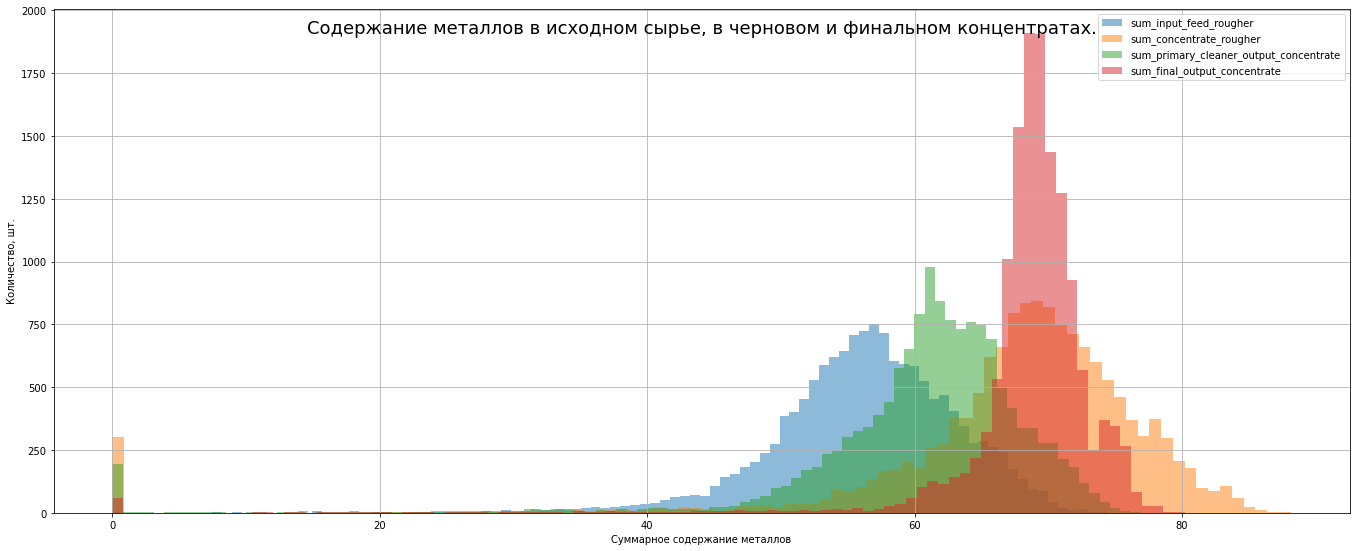

In [14]:
BINS = 100

fig = plt.figure(figsize=(18, 7))
ax = fig.add_axes([0,0,1,1])
ax.grid()
ttl = fig.suptitle('Содержание металлов в исходном сырье, в черновом и финальном концентратах.', fontsize=18)
plt.xlabel('Суммарное содержание металлов')
plt.ylabel('Количество, шт.')
for stage in sum_concentrate:
    plt.hist(gold_recovery_train[stage],
             alpha=0.5, 
             label=stage,
             bins=BINS)
plt.legend(loc='upper right')
plt.show()


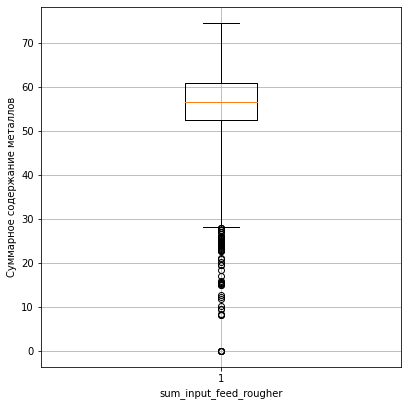

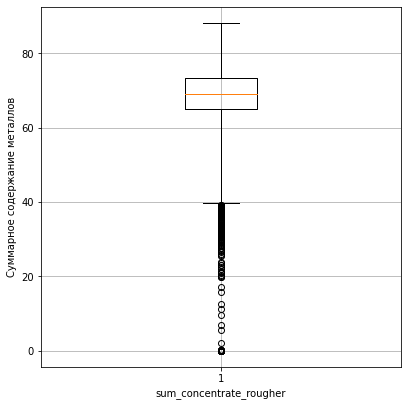

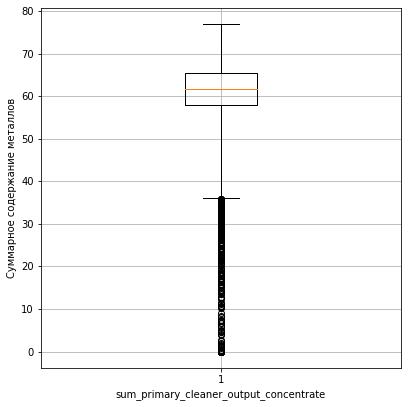

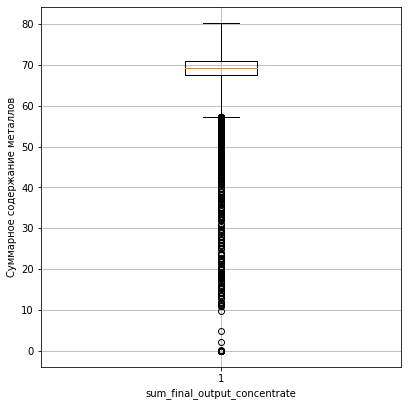

In [15]:
for stage in sum_concentrate:
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_axes([0,0,1,1])
    ax.grid()
    plt.xlabel(stage)
    plt.ylabel('Суммарное содержание металлов')
    plt.boxplot(gold_recovery_train[stage], 
                whis = 3,
                widths = 0.2)
    plt.show()

По распределению видно, что присутствуют выбросы: 0 до 57 в зависимости этапа обогащения, которые можно удалить.

In [16]:
gold_recovery_train = gold_recovery_train[gold_recovery_train['sum_input_feed_rougher']>38]
gold_recovery_train = gold_recovery_train[gold_recovery_train['sum_concentrate_rougher']>42]
gold_recovery_train = gold_recovery_train[gold_recovery_train['sum_primary_cleaner_output_concentrate']>40]
gold_recovery_train = gold_recovery_train[gold_recovery_train['sum_final_output_concentrate']>58]
gold_recovery_train.info()

<class 'pandas.core.frame.DataFrame'>

Int64Index: 12837 entries, 0 to 14148

Data columns (total 92 columns):

 #   Column                                              Non-Null Count  Dtype  

---  ------                                              --------------  -----  

 0   date                                                12837 non-null  object 

 1   final.output.concentrate_ag                         12837 non-null  float64

 2   final.output.concentrate_pb                         12837 non-null  float64

 3   final.output.concentrate_sol                        12837 non-null  float64

 4   final.output.concentrate_au                         12837 non-null  float64

 5   final.output.recovery                               12837 non-null  float64

 6   final.output.tail_ag                                12837 non-null  float64

 7   final.output.tail_pb                                12837 non-null  float64

 8   final.output.tail_sol                               12837 non-n

Построим гистограммы и "ящики с усами" после удаления выбросов.

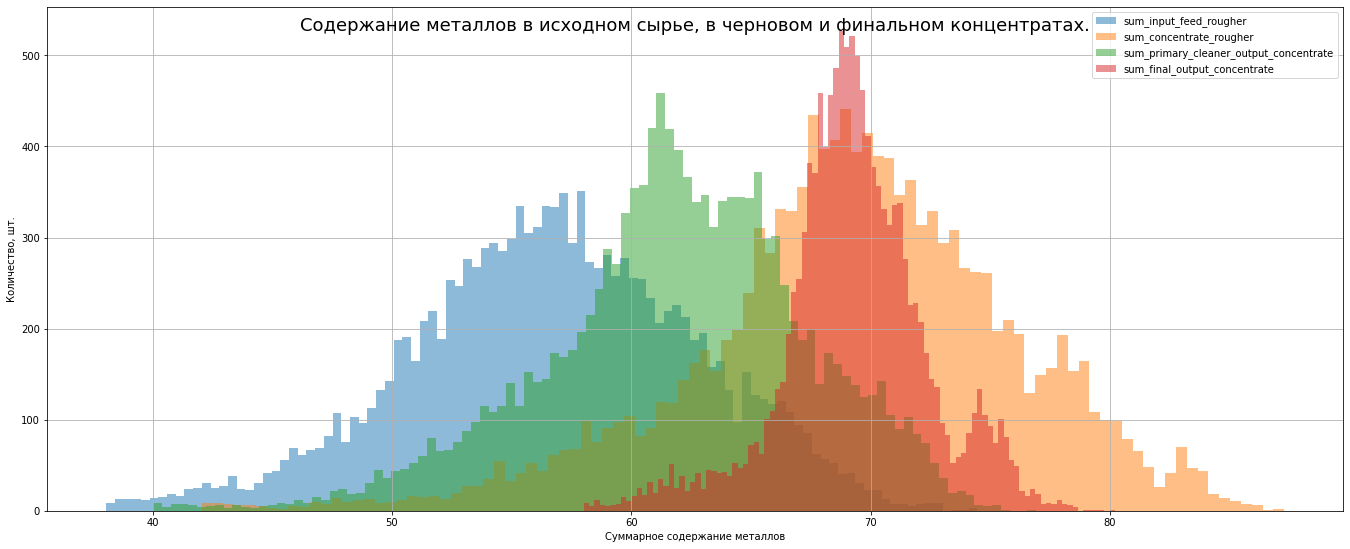

In [17]:
BINS = 100

fig = plt.figure(figsize=(18, 7))
ax = fig.add_axes([0,0,1,1])
ax.grid()
ttl = fig.suptitle('Содержание металлов в исходном сырье, в черновом и финальном концентратах.', fontsize=18)
plt.xlabel('Суммарное содержание металлов')
plt.ylabel('Количество, шт.')
for stage in sum_concentrate:
    plt.hist(gold_recovery_train[stage],
             alpha=0.5, 
             label=stage,
             bins=BINS)
plt.legend(loc='upper right')
plt.show()

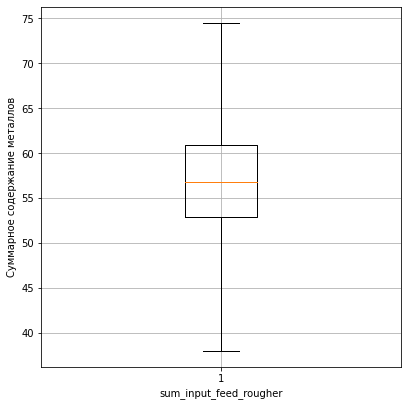

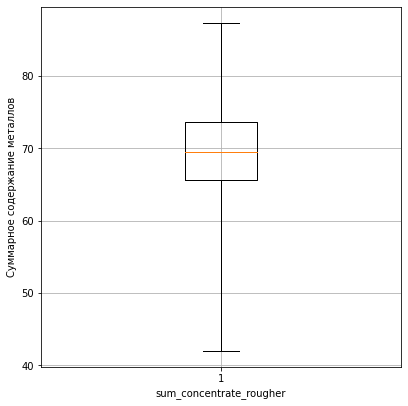

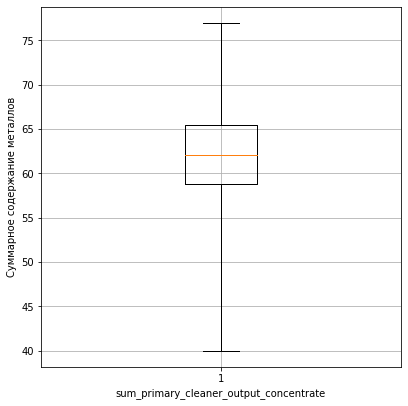

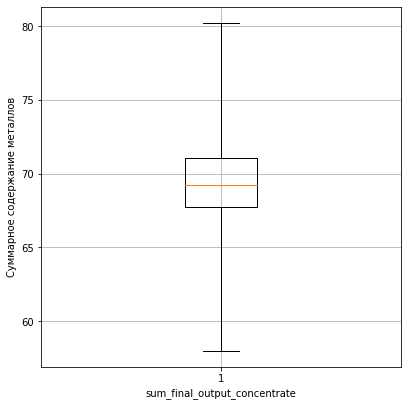

In [18]:
for stage in sum_concentrate:
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_axes([0,0,1,1])
    ax.grid()
    plt.xlabel(stage)
    plt.ylabel('Суммарное содержание металлов')
    plt.boxplot(gold_recovery_train[stage], 
                whis = 3,
                widths = 0.2)
    plt.show()

## Модель

Создадим переменные для признаков и целевого признака.

In [19]:
#обучающая выборка
columns = gold_recovery_test.columns #колонки, которые в тестовой выборке
feature = gold_recovery_train[columns] #формируем признаки, выбирает в обучающей выборке только тетстовые признаки
feature = feature.drop(['date'],axis=1) #удалим столбец-идентификатор (date), который не будет использоваться в модели
target = gold_recovery_train[['rougher.output.recovery','final.output.recovery']] #формируем целевые признаки

display(feature.info())
display(target.info())

<class 'pandas.core.frame.DataFrame'>

Int64Index: 12837 entries, 0 to 14148

Data columns (total 52 columns):

 #   Column                                      Non-Null Count  Dtype  

---  ------                                      --------------  -----  

 0   primary_cleaner.input.sulfate               12837 non-null  float64

 1   primary_cleaner.input.depressant            12837 non-null  float64

 2   primary_cleaner.input.feed_size             12837 non-null  float64

 3   primary_cleaner.input.xanthate              12837 non-null  float64

 4   primary_cleaner.state.floatbank8_a_air      12837 non-null  float64

 5   primary_cleaner.state.floatbank8_a_level    12837 non-null  float64

 6   primary_cleaner.state.floatbank8_b_air      12837 non-null  float64

 7   primary_cleaner.state.floatbank8_b_level    12837 non-null  float64

 8   primary_cleaner.state.floatbank8_c_air      12837 non-null  float64

 9   primary_cleaner.state.floatbank8_c_level    12837 non-null  float64



None

<class 'pandas.core.frame.DataFrame'>

Int64Index: 12837 entries, 0 to 14148

Data columns (total 2 columns):

 #   Column                   Non-Null Count  Dtype  

---  ------                   --------------  -----  

 0   rougher.output.recovery  12837 non-null  float64

 1   final.output.recovery    12837 non-null  float64

dtypes: float64(2)

memory usage: 300.9 KB


None

In [20]:
#тестовая выборка
target_test = gold_recovery_full[['date','rougher.output.recovery','final.output.recovery']]
gold_recovery_test = gold_recovery_test.merge(target_test,on=['date'],how='left')
gold_recovery_test = gold_recovery_test.dropna()
target_test = gold_recovery_test[['rougher.output.recovery','final.output.recovery']]
feature_test =  gold_recovery_test.drop(['date','rougher.output.recovery','final.output.recovery'],axis=1)

display(feature_test.info())
display(target_test.info())

<class 'pandas.core.frame.DataFrame'>

Int64Index: 5290 entries, 0 to 5289

Data columns (total 52 columns):

 #   Column                                      Non-Null Count  Dtype  

---  ------                                      --------------  -----  

 0   primary_cleaner.input.sulfate               5290 non-null   float64

 1   primary_cleaner.input.depressant            5290 non-null   float64

 2   primary_cleaner.input.feed_size             5290 non-null   float64

 3   primary_cleaner.input.xanthate              5290 non-null   float64

 4   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64

 5   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64

 6   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64

 7   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64

 8   primary_cleaner.state.floatbank8_c_air      5290 non-null   float64

 9   primary_cleaner.state.floatbank8_c_level    5290 non-null   float64

 1

None

<class 'pandas.core.frame.DataFrame'>

Int64Index: 5290 entries, 0 to 5289

Data columns (total 2 columns):

 #   Column                   Non-Null Count  Dtype  

---  ------                   --------------  -----  

 0   rougher.output.recovery  5290 non-null   float64

 1   final.output.recovery    5290 non-null   float64

dtypes: float64(2)

memory usage: 124.0 KB


None

Напишим функцию для расчета метрики sMAPE

In [21]:
def smape(target, predict):
    predict_rougher = predict[:,0]
    target__rougher = target[:,0]
    predict_final = predict[:,1]
    target__final = target[:,1]
    
    smape_rougher = (np.sum(abs(target__rougher - predict_rougher) /
                            ((abs(target__rougher) + abs(predict_rougher)) / 2)) /
                     len(target__rougher) * 100
                    )
    
   
    smape_final = (np.sum(abs(target__final - predict_final) / 
                          ((abs(target__final) + abs(predict_final)) / 2)) /
                   len(target__final) * 100
                  )
    
    
    return 0.25 * smape_rougher + 0.75 * smape_final

Обучим разные модели и оценим их качество кросс-валидацией. В качестве моделей будем использовать: линейнную регрессию, дерево решений и случайнный лес.

In [22]:
size_sample = int(len(gold_recovery_test) / 5) #формируем длину датасета для кросс-валидации, блоков будет 5

In [23]:
# кросс-валидация Линейная регрессия

scores = []

for i in range(0, len(gold_recovery_test), size_sample):
    feature_valid = feature[i: i + size_sample]
    feature_train = feature.drop(feature_valid.index)

    target_valid = target[i: i + size_sample]
    target_valid_arr = np.array(target_valid)
    target_train = target.drop(target_valid.index)

    model = LinearRegression().fit(feature_train, target_train)
    predict = model.predict(feature_valid)

    scores.append(smape(target_valid_arr, predict))


display('Итоговый sMAPE:', np.mean(scores))

'Итоговый sMAPE:'

7.929815944519424

In [24]:
# кросс-валидация Случайны лес
def smape_1(target, predict):
    smape = (np.sum(abs(target - predict) /
                            ((abs(target) + abs(predict)) / 2)) /
                     len(target) * 100
                    )
    return smape

target_train_rougher = target['rougher.output.recovery']
target_train_final = target['final.output.recovery']

parametrs = { 'n_estimators': [20],
              'max_depth': range (1, 5, 1),
              'min_samples_leaf': range (2, 4, 2),
              'min_samples_split': range (2, 4, 2) }

scorer = make_scorer(smape_1, greater_is_better = False)

In [25]:
grid_rougher = RandomForestRegressor()
grid_rougher = (GridSearchCV(grid_rougher, parametrs, scoring = scorer, n_jobs=-1, cv=5)
                .fit(feature, target_train_rougher)
               )

grid_rougher_best_params = grid_rougher.best_params_
grid_rougher_best_score = grid_rougher.best_score_

grid_final = RandomForestRegressor()
grid_final = (GridSearchCV(grid_final, parametrs, scoring = scorer, n_jobs=-1, cv=5)
              .fit(feature, target_train_final)
             )

grid_final_best_params = grid_final.best_params_
grid_final_best_score = grid_final.best_score_

In [26]:
display ('Лучшие параметры для чернового концентрата: ')
display(grid_rougher_best_params)
display ('Лучшая метрика для чернового концентрата: ')
display(grid_rougher_best_score)
display ('Лучшие параметры для финального концентрата: ')
display(grid_final_best_params)
display ('Лучшая метрика для финального концентрата: ')
display(grid_final_best_score)

'Лучшие параметры для чернового концентрата: '

{'max_depth': 4,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 20}

'Лучшая метрика для чернового концентрата: '

-5.968114313899532

'Лучшие параметры для финального концентрата: '

{'max_depth': 4,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 20}

'Лучшая метрика для финального концентрата: '

-8.383308452792852

In [27]:
predict_rougher = grid_rougher.predict(feature)
scores_rougher = smape_1(np.array(target_train_rougher), predict_rougher)
predict_final = grid_final.predict(feature)
scores_final = smape_1(np.array(target_train_final), predict_final)
display('Итоговый sMAPE', 0.25 * scores_rougher + 0.75 * scores_final )

'Итоговый sMAPE'

6.347567971818509

In [28]:
#кросс-валидация Дерево решений

for depth in range(1, 6):
    scores = []
    for i in range(0, len(gold_recovery_test), size_sample):
        feature_valid = feature[i: i + size_sample]
        feature_train = feature.drop(feature_valid.index)

        target_valid = target[i: i + size_sample]
        target_valid_arr=np.array(target_valid)
        target_train = target.drop(target_valid.index)
        model = (DecisionTreeRegressor(random_state=1234, max_depth=depth)
                 .fit(feature_train, target_train)
                )
        predict = model.predict(feature_valid)

        scores.append(smape(target_valid_arr, predict))

    print('Итоговый sMAPE при depth =', str(depth) + ':', np.mean(scores))

Итоговый sMAPE при depth = 1: 8.803614382155372

Итоговый sMAPE при depth = 2: 8.3824218316079

Итоговый sMAPE при depth = 3: 8.331508780134113

Итоговый sMAPE при depth = 4: 8.374561591523804

Итоговый sMAPE при depth = 5: 8.677863817605687


In [29]:
#константная модель

median_rougher_recovery = pd.Series(gold_recovery_train['rougher.output.recovery'].median(), index=gold_recovery_test.index)
median_final_recovery = pd.Series(gold_recovery_train['final.output.recovery'].median(), index=gold_recovery_test.index)


smape_rougher = (sum(abs(gold_recovery_test['rougher.output.recovery'] - median_rougher_recovery) /
                     ((abs(gold_recovery_test['rougher.output.recovery']) + abs(median_rougher_recovery)) / 2)) /
                     len(gold_recovery_test['rougher.output.recovery']) * 100
                )

smape_final = (sum(abs(gold_recovery_test['final.output.recovery'] - median_final_recovery) /
                     ((abs(gold_recovery_test['final.output.recovery']) + abs(median_final_recovery)) / 2)) /
                     len(gold_recovery_test['final.output.recovery']) * 100
                )

display('sMAPE для медианной константной модели:', smape_rougher * 0.25 + smape_final * 0.75)

'sMAPE для медианной константной модели:'

9.427228128489613

Таким образом, наилучшая модель - это Случайный лес c итоговым sMAPE = 6.35 и следующими параметрами: 
* max_depth: 4,
* min_samples_leaf: 2,
* min_samples_split: 2,
* n_estimators: 20.   
Данная модель имеет наиболее низкий показатель итоговый sMAPE. Выберем ее для проверки на тестовой выборке.

In [30]:
model = (RandomForestRegressor(max_depth=4, min_samples_leaf=2, min_samples_split=2, n_estimators=20)
         .fit(feature, target)
        )
predict = model.predict(feature_test)
scores = smape(np.array(target_test), predict)

display('Итоговый sMAPE', scores)

'Итоговый sMAPE'

9.167418540053571

Таким образом, модель Случайный лес cо следующими параметрами: 
* max_depth: 4,
* min_samples_leaf: 2,
* min_samples_split: 2,
* n_estimators': 20
Показала метрику итогового sMAPE = 9.17 на тестовой выборке.
Полученная модель поможет лучше прогнозировать коэффициент восстановления золота из золотосодержащей руды для того, чтобы не запускать предприятие с убыточными характеристиками.